# XGBoost Regressor 
The goal of this script is to document the generic steps in hyper parameter tuning and training an XGBoost Regression model.
This can be used to produce a baseline model to compare to, but in practice, more modifications will be necessary for fine tuning and creating the best possible model.
#### Useful Resources:
 - Source Documentation: https://xgboost.readthedocs.io/en/stable/
 - Blog Post on how XGBoost works and details of hyper parameter tuning: https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

In [68]:
##### Imports #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
# reduce_memory_usage optimizes the amount of memory required for each column. Pandas defaults to 64 bit data types, but this is wasteful.
# This function looks at the range of values and assigns the most optimal type that keeps the data in tact

# Source for this code: https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
    if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# Read in data and run reduce memory function
# TEST EXAMPLE USING BOSTON DATASET
from sklearn.datasets import load_boston
boston = load_boston()
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names
data['PRICE'] = boston.target
reduced_df = reduce_memory_usage(data)
X, y = reduced_df.loc[:,reduced_df.columns != 'PRICE'],reduced_df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Memory usage of dataframe is 0.05 MB
Memory usage after optimization is: 0.05 MB
Decreased by 5.3%


C:\Users\EAdomaitis\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing data

In [114]:
def XGBRegressor_Training (xgb_params, X_train, X_test, y_train, y_test):
    # Parameter documentation: https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
    
    # Perform GridSearch
    xgb_model = xgb.XGBRegressor()
    xgb_grid = GridSearchCV(estimator=xgb_model,param_grid=xgb_params,cv = 2,n_jobs = -1,verbose=True)
    xgb_grid.fit(X_train, y_train)
    print('XGBoost Hyper Parameter Optimization Best Parameters:',xgb_grid.best_params_,'\n')
    
    # Retrain using the best performing parameter combination
    # Define xgb specific data matrices
    dtrain = xgb.DMatrix(data=X_train.values,feature_names=X_train.columns,label=y_train.values)
    dtest = xgb.DMatrix(data=X_test.values,feature_names=X_test.columns,label=y_test.values)
    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    
    
    xgb_reg = xgb.train(params=xgb_grid.best_params_,dtrain=dtrain, num_boost_round=10, evals=evallist)   

    # Make predictions
    xgb_preds = xgb_reg.predict(dtest)
    
    # Store error metrics
    xgb_error_metrics = {'mae':0,'rmse':0,'mse':0,'r2':0,'adjusted_r2':0}
    xgb_error_metrics['mse'] = mean_squared_error(y_test, xgb_preds)
    xgb_error_metrics['rmse'] = np.sqrt(xgb_error_metrics['mse'])
    xgb_error_metrics['mae'] = mean_absolute_error(y_test, xgb_preds)
    xgb_error_metrics['r2'] = r2_score(y_test,xgb_preds)
    n = y_test.shape[0] # Number of rows
    k = len(X_test.columns) # Number of independent variables
    xgb_error_metrics['adjusted_r2'] = 1 - ((1-xgb_error_metrics['r2'])*(n-1)/(n-k-1)) # Adjusted R^2 calculation
    
    # Print error metrics
    print("\n----------------- FINAL MODEL ERROR METRICS -----------------")
    print("MSE: %f" % (xgb_error_metrics['mse']))
    print("RMSE: %f" % (xgb_error_metrics['rmse']))
    print("MAE: %f" % (xgb_error_metrics['mae']))
    print("R Squared: %f" % (xgb_error_metrics['r2']))
    print("Adjusted R Squared: %f" % (xgb_error_metrics['adjusted_r2']))
    
    # Returns the model, the best parameter list, predicted values, and common error metrics
    return xgb_reg, xgb_grid.best_params_, xgb_preds, xgb_error_metrics, xgb_reg.get_fscore(), dtrain, dtest
    

In [117]:
# Define XGBoost hyperparameters to optimize. 
# Parameter documentation: https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
xgb_params = {'objective':['reg:squarederror'], # 'reg:squarederror': for linear regression; 'reg:logistic': for logistic regression; 'binary:logistic': for logistic regression — with output of the probabilities
          'learning_rate': [0.05, 0.1, 0.3], # The learning rate determines the step size at each iteration while your model optimizes toward its objective. A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum. The value must be between 0 and 1. Default is 0.3
          'max_depth': [6, 8, 10], # The maximum depth per tree. A deeper tree might increase the performance, but also the complexity and chances to overfit.The value must be an integer greater than 0. Default is 6.
          'num_parallel_tree': [50, 100], # The number of trees in our ensemble. Equivalent to the number of boosting rounds. The value must be an integer greater than 0. Default is 100.
          'subsample': [0.7], # Represents the fraction of observations to be sampled for each tree. A lower values prevent overfitting but might lead to under-fitting. The value must be between 0 and 1. Default is 1.
          'colsample_bytree': [0.3, 0.7], # Represents the fraction of columns to be randomly sampled for each tree. It might improve overfitting. The value must be between 0 and 1. Default is 1.
          'alpha': [0, 1, 5, 10], # L1 regularization on the weights (Lasso Regression). When working with a large number of features, it might improve speed performances. It can be any integer. Default is 0.
          'lambda': [0, 1, 5, 10], # lambda L2 regularization on the weights (Ridge Regression). It might help to reduce overfitting. It can be any integer. Default is 1.
          'gamma': [0, 1, 5, 10], # Gamma is a pseudo-regularisation parameter (Lagrangian multiplier), and depends on the other parameters. The higher Gamma is, the higher the regularization. It can be any integer. Default is 0.
          'eval_metric':['rmse']}

# Call the function to run hyperparameter optimization and training of final model
xgb_reg, xgb_params, xgb_preds, xgb_errors, xgb_feature_importances, dtrain, dtest = XGBRegressor_Training(xgb_params,X_train, X_test, y_train, y_test)


Fitting 2 folds for each of 2304 candidates, totalling 4608 fits
XGBoost Hyper Parameter Optimization Best Parameters: {'alpha': 0, 'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'gamma': 0, 'lambda': 0, 'learning_rate': 0.1, 'max_depth': 6, 'num_parallel_tree': 100, 'objective': 'reg:squarederror', 'subsample': 0.7} 

[0]	eval-rmse:22.03002	train-rmse:21.40085
[1]	eval-rmse:19.87312	train-rmse:19.29691
[2]	eval-rmse:17.94547	train-rmse:17.40452
[3]	eval-rmse:16.22563	train-rmse:15.70299
[4]	eval-rmse:14.67440	train-rmse:14.16987
[5]	eval-rmse:13.28672	train-rmse:12.79083
[6]	eval-rmse:12.05876	train-rmse:11.55297
[7]	eval-rmse:10.94698	train-rmse:10.43317
[8]	eval-rmse:9.96664	train-rmse:9.42715
[9]	eval-rmse:9.09979	train-rmse:8.52323

----------------- FINAL MODEL ERROR METRICS -----------------
MSE: 82.806259
RMSE: 9.099794
MAE: 7.912731
R Squared: -0.000881
Adjusted R Squared: -0.148739


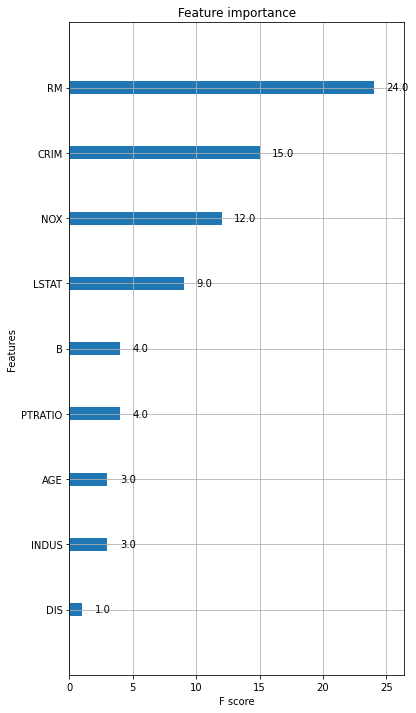

In [45]:
# Display plot of XGBoost feature importances
xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [4, 15]
plt.show()

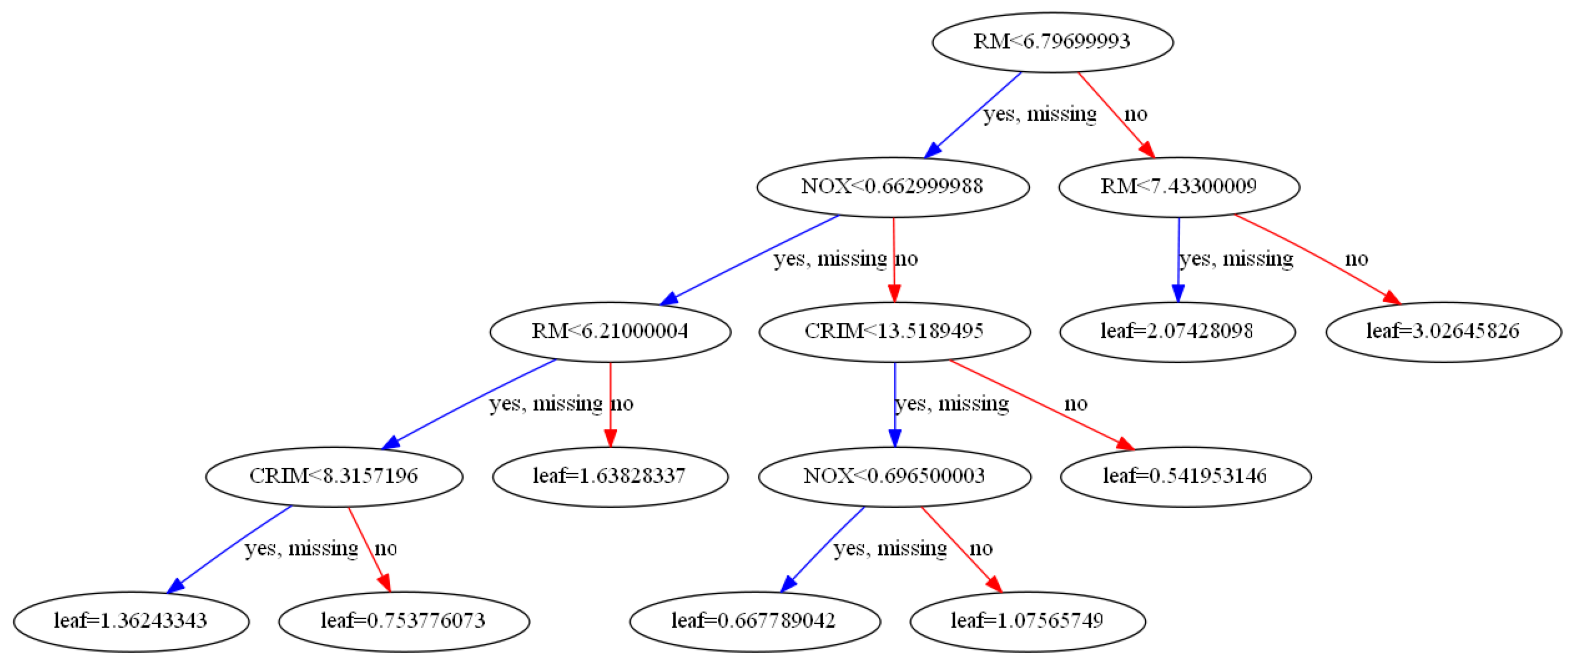

In [48]:
# Display plot of first tree
xgb.plot_tree(xgb_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 20]
plt.show()

In [85]:
# Save the model
pickle.dump(xgb_reg, open("xgb_reg.pkl", "wb"))

# Saving test DMatrix
dtest.save_binary('dtest.buffer')

In [86]:
# load the model
xgb_reg_loaded = pickle.load(open("xgb_reg.pkl", "rb"))

# Reload in test DMatrix 
dtest2 = xgb.DMatrix('dtest.buffer')

In [113]:
# Sanity Checks to ensure model is the same as before
print("----------------- SANITY CHECKS -----------------")
print("Is the sum of difference between predictions zero?",(xgb_reg.predict(dtest) - xgb_reg_loaded.predict(dtest2)).sum() == 0.0)
print("Do the feature importances dictionaries match?",xgb_reg.get_fscore() == xgb_reg_loaded.get_fscore())

----------------- SANITY CHECKS -----------------
Is the sum of difference between predictions zero? True
Do the feature importances dictionaries match? True
